# Classification Metrics 2 
Author: Kim Hazed Delfino

# Imports 

In [141]:
import pandas as pd
import numpy as np
# Libs for plots
import matplotlib.pyplot as plt
import seaborn as sns
# Necessary libs 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay


## Load the Data

In [142]:
path = r"C:\Users\kdelfino\Documents\GitHub\Classification_metrics_2\bank_modified.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  4521 non-null   int64
 1   balance              4521 non-null   int64
 2   duration             4521 non-null   int64
 3   campaign             4521 non-null   int64
 4   pdays                4521 non-null   int64
 5   previous             4521 non-null   int64
 6   job_blue-collar      4521 non-null   int64
 7   job_entrepreneur     4521 non-null   int64
 8   job_housemaid        4521 non-null   int64
 9   job_management       4521 non-null   int64
 10  job_retired          4521 non-null   int64
 11  job_self-employed    4521 non-null   int64
 12  job_services         4521 non-null   int64
 13  job_student          4521 non-null   int64
 14  job_technician       4521 non-null   int64
 15  job_unemployed       4521 non-null   int64
 16  job_unknown          452

In [144]:
df.head()

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,y_yes
0,30,1787,79,1,-1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,33,4789,220,1,339,4,0,0,0,0,...,0,1,0,1,0,0,0,1,1,0
2,35,1350,185,1,330,1,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
3,30,1476,199,4,-1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0
4,59,0,226,1,-1,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [145]:
# Check for duplites in our dataset
df.duplicated().sum()

0

## Assign Feature Matrices and Target Vector

In [146]:
# Train test split
X = df.drop(columns="y_yes")
y = df["y_yes"]

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=42)
y.value_counts()

0    4000
1     521
Name: y_yes, dtype: int64

- Looks like our target dataset is imbalanced by quite a lot 

### Custom Class to Instantiate Model and Create Reports/Visuals

In [147]:
class ClfMetrics:
    def __init__(self, model, X_train, X_test, y_train, y_test, 
                 labels):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        self.labels = labels

        # Train model 
        scaler = StandardScaler()
        self.model_pipe = make_pipeline(scaler,model)
        self.model_pipe.fit(X_train,y_train)
        # set hyperparams 
        self.show_params = self.model_pipe.get_params()
        # set prediction
        self.model_train_pred = self.model_pipe.predict(X_train)
        self.model_test_pred = self.model_pipe.predict(X_test)
        # set classfication report
        self.train_dt_report = classification_report(y_train,self.model_train_pred,
                                                target_names=labels)
        self.test_dt_report = classification_report(y_test, self.model_test_pred,
                                            target_names=labels)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.model_test_pred).ravel()
        self.sensitivity = self.tp / (self.tp/self.fn)
        self.specificity = self.tn / (self.tn/self.fp)

    # Display Confusion Report 
    def get_report(self):
        report = f"""{self.model} Train Metric Scores: \n {self.train_dt_report} \n
        {self.model} Test Metric Scores: \n {self.test_dt_report}
        Sensitivitiy = {self.sensitivity}%
        Specificity = {self.specificity}% """
        return print(report)

    def get_visuals(self, normalize = None):


        # Display Confusion Matrix
        fig, axes = plt.subplots(ncols= 2, figsize=(10,5))
        ConfusionMatrixDisplay.from_predictions(self.y_train, 
                                                self.model_train_pred,
                                                ax=axes[0],
                                                cmap="Blues",
                                                normalize=normalize)
        axes[0].set_title("Train CM")
          
        ConfusionMatrixDisplay.from_predictions(self.y_test, 
                                                self.model_test_pred,
                                                ax=axes[1],
                                                cmap="Reds",
                                                normalize=normalize)
        axes[1].set_title("Test CM")
        
        return plt.show()
        
    def run_gs(self,param_matrix:dict) -> dict:
        self.gs_pipe = GridSearchCV(self.model_pipe,param_matrix)
        self.gs_pipe.fit(X_train, y_train)
        print(f"Testing Accuracy : {round(self.gs_pipe.best_estimator_.score(X_test,y_test)*100,2)}")
        print(f"Training Accuracy : {round(self.gs_pipe.best_estimator_.score(X_train,y_train)*100,2)}")
        print(self.model)
        self.test_proba = self.gs_pipe.predict_proba(X_test)[:,1]
        
        return self.gs_pipe.best_params_
    
    def show_roc(self):
        print(f"ROC AUC score : {roc_auc_score(self.y_test,self.test_proba)}")
        return RocCurveDisplay.from_predictions(self.y_test, self.test_proba)


## Logistic Regression

In [148]:
#set labels for report
labels = ["No", "Yes"]

# Instantiate LR model
lr =  ClfMetrics(LogisticRegression(solver="liblinear"), 
                 X_train, X_test, y_train , y_test, labels)

In [149]:
lr.get_report()

LogisticRegression(solver='liblinear') Train Metric Scores: 
               precision    recall  f1-score   support

          No       0.90      0.98      0.94      2994
         Yes       0.58      0.20      0.30       396

    accuracy                           0.89      3390
   macro avg       0.74      0.59      0.62      3390
weighted avg       0.86      0.89      0.87      3390
 

        LogisticRegression(solver='liblinear') Test Metric Scores: 
               precision    recall  f1-score   support

          No       0.92      0.98      0.95      1006
         Yes       0.60      0.27      0.37       125

    accuracy                           0.90      1131
   macro avg       0.76      0.62      0.66      1131
weighted avg       0.88      0.90      0.88      1131

        Sensitivitiy = 91.0%
        Specificity = 23.0% 


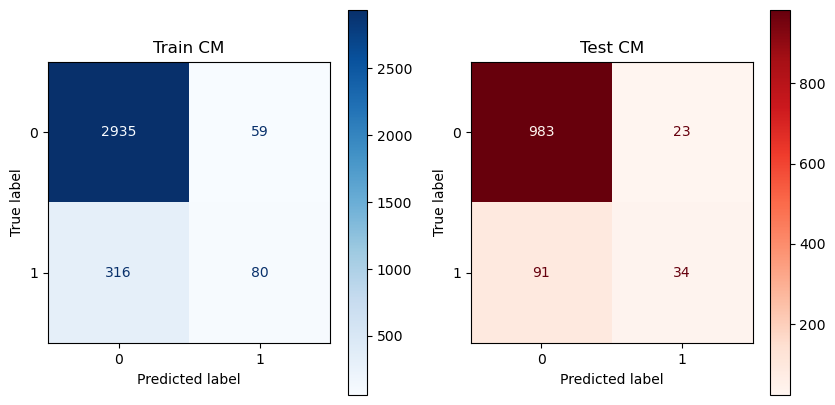

In [150]:
lr.get_visuals()

In [151]:
lr.show_params

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(solver='liblinear'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(solver='liblinear'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [152]:
lr_param_matrix = {
    'logisticregression__penalty':["l1", "l2"],
    'logisticregression__C' : [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]
                   }

In [153]:
lr.run_gs(lr_param_matrix)

Testing Accuracy : 89.57
Training Accuracy : 89.14
LogisticRegression(solver='liblinear')


{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}

ROC AUC score : 0.8664970178926441


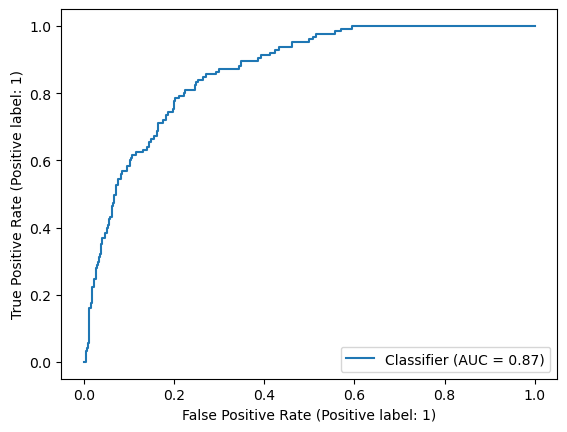

In [154]:
lr.show_roc()

- Overall , Our model accuracy suffers due to the target's distribution imbalance
- Our model needs to get more `Yes` in our dataset to better predict patterns and learn from it
- I think with this dataset we care more about getting as much `True Yes` or True positive than True negative, So we can put more value on `Sensitivity score` or `Recall score` since it penalize the `False negative` predictions or those who would've said `Yes` but we predicted as `No`